In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline
import os
import numpy as np
import pandas as pd
import os
from PIL import Image
from random import shuffle
import matplotlib.pyplot as plt

In [2]:
train_path="./Class7/Train/"
train_label_path = "./Class7/train_labels/Labels.txt"
test_path = "./Class7/Test/"
test_label_path = "./Class7/test_labels/Labels.txt"
label=[]
data1=[]
counter=0
IMG_SIZE = 28

In [6]:
def get_labels(path):
    labels_data = pd.read_csv(path)
    labels_data = labels_data["1"].str.split("\t", expand = True)
    return labels_data[1]

def load_images_to_array(path):
    training_data = []
    for img in os.listdir(path):
        image_full_path = os.path.join(path,img)
        img = Image.open(image_full_path)
        img = img.convert("L")
        img = img.resize((IMG_SIZE,IMG_SIZE),Image.ANTIALIAS)
        training_data.append([np.array(img)])
    #training_data = shuffle(training_data)
    return training_data

def convert_labels_to_one_not_encode(labels):
    trainLabels = []
    for i in range(0, len(labels)):
        lab = labels[i]
        if lab == "0":
            trainLabels.append(np.array([1,0]))
        else:
            trainLabels.append(np.array([0,1]))
    trainLabels = np.array(trainLabels)
    return trainLabels

In [7]:
train_features = load_images_to_array(train_path)
train_labels = get_labels(train_label_path)
trainImages = np.array([i for i in train_features]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
trainLabels = convert_labels_to_one_not_encode(train_labels)
test_features = load_images_to_array(test_path)
#normalize - didn't work
#test_features = np.array(test_features) / 255
test_labels = get_labels(test_label_path)
testImages = np.array([i for i in test_features]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
testLabels = convert_labels_to_one_not_encode(test_labels)

train_X = trainImages
train_y = trainLabels
#train_X = train_X.astype('float32')
test_X = testImages
#test_X = test_X.astype('float32')
test_y = testLabels

In [8]:
trainLabels

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [9]:
training_iters = 50 
learning_rate = 0.0001 
batch_size = 128

In [10]:
# MNIST data input (img shape: 28*28)
n_input = IMG_SIZE

# MNIST total classes (0-9 digits)
n_classes = 2

In [11]:
#both placeholders are of type float
x = tf.placeholder("float", [None, IMG_SIZE,IMG_SIZE,1])
y = tf.placeholder("float", [None, n_classes])

In [12]:
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x) 

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')

In [13]:
#to reuse the variables set reuse=tf.AUTO_REUSE
with tf.variable_scope("foo", reuse=tf.AUTO_REUSE):
    weights = {
        'wc1': tf.get_variable('W0', shape=(3,3,1,32), initializer=tf.contrib.layers.xavier_initializer()), 
        'wc2': tf.get_variable('W1', shape=(3,3,32,64), initializer=tf.contrib.layers.xavier_initializer()), 
        'wc3': tf.get_variable('W2', shape=(3,3,64,128), initializer=tf.contrib.layers.xavier_initializer()), 
        'wd1': tf.get_variable('W3', shape=(4*4*128,128), initializer=tf.contrib.layers.xavier_initializer()), 
        'out': tf.get_variable('W6', shape=(128,n_classes), initializer=tf.contrib.layers.xavier_initializer()), 
    }
    biases = {
        'bc1': tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
        'bc2': tf.get_variable('B1', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
        'bc3': tf.get_variable('B2', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
        'bd1': tf.get_variable('B3', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
        'out': tf.get_variable('B4', shape=(2), initializer=tf.contrib.layers.xavier_initializer()),
    }

In [14]:
def conv_net(x, weights, biases):  

    # here we call the conv2d function we had defined above and pass the input image x, weights wc1 and bias bc1.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 14*14 matrix.
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    # here we call the conv2d function we had defined above and pass the input image x, weights wc2 and bias bc2.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 7*7 matrix.
    conv2 = maxpool2d(conv2, k=2)

    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 4*4.
    conv3 = maxpool2d(conv3, k=2)


    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Output, class prediction
    # finally we multiply the fully connected layer with the weights and add a bias term. 
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [15]:
with tf.variable_scope("foo", reuse=tf.AUTO_REUSE):
    pred = conv_net(x, weights, biases)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y))

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [16]:
#Here you check whether the index of the maximum value of the predicted image is equal to the actual labelled image. and both will be a column vector.
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

#calculate accuracy across all the given images and average them out. 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [17]:
init = tf.global_variables_initializer()

In [18]:
with tf.Session() as sess:
    sess.run(init) 
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    for i in range(training_iters):
        for batch in range(len(train_X)//batch_size):
            batch_x = train_X[batch*batch_size:min((batch+1)*batch_size,len(train_X))]
            batch_y = train_y[batch*batch_size:min((batch+1)*batch_size,len(train_y))]    
            # Run optimization op (backprop).
                # Calculate batch loss and accuracy
            opt = sess.run(optimizer, feed_dict={x: batch_x,
                                                              y: batch_y})
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y})
        print("Iter " + str(i) + ", Loss= " + \
                      "{:.6f}".format(loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(acc))
        print("Optimization Finished!")

        # Calculate accuracy for all 10000 mnist test images
        test_acc,valid_loss = sess.run([accuracy,cost], feed_dict={x: test_X,y : test_y})
        train_loss.append(loss)
        test_loss.append(valid_loss)
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)
        print("Testing Accuracy:","{:.5f}".format(test_acc))
    summary_writer.close()

Iter 0, Loss= 2.299486, Training Accuracy= 0.12500
Optimization Finished!
Testing Accuracy: 0.13043
Iter 1, Loss= 0.540365, Training Accuracy= 0.87500
Optimization Finished!
Testing Accuracy: 0.86957
Iter 2, Loss= 0.438484, Training Accuracy= 0.87500
Optimization Finished!
Testing Accuracy: 0.86957
Iter 3, Loss= 0.452806, Training Accuracy= 0.87500
Optimization Finished!
Testing Accuracy: 0.87043
Iter 4, Loss= 0.527353, Training Accuracy= 0.82812
Optimization Finished!
Testing Accuracy: 0.85217
Iter 5, Loss= 0.388345, Training Accuracy= 0.87500
Optimization Finished!
Testing Accuracy: 0.86957
Iter 6, Loss= 0.399048, Training Accuracy= 0.87500
Optimization Finished!
Testing Accuracy: 0.86957
Iter 7, Loss= 0.403540, Training Accuracy= 0.87500
Optimization Finished!
Testing Accuracy: 0.86957
Iter 8, Loss= 0.384750, Training Accuracy= 0.87500
Optimization Finished!
Testing Accuracy: 0.86957
Iter 9, Loss= 0.388229, Training Accuracy= 0.87500
Optimization Finished!
Testing Accuracy: 0.86957


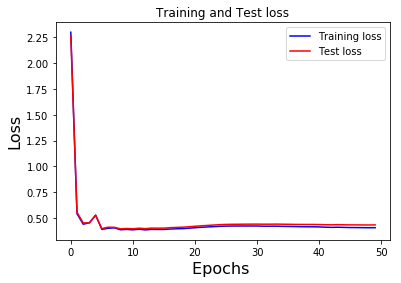

<Figure size 432x288 with 0 Axes>

In [19]:
plt.plot(range(len(train_loss)), train_loss, 'b', label='Training loss')
plt.plot(range(len(train_loss)), test_loss, 'r', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()

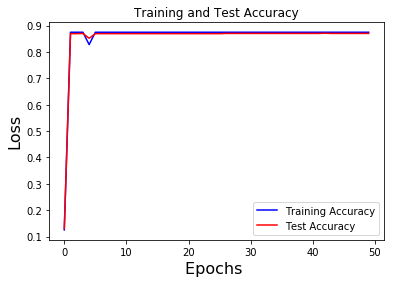

<Figure size 432x288 with 0 Axes>

In [20]:
plt.plot(range(len(train_loss)), train_accuracy, 'b', label='Training Accuracy')
plt.plot(range(len(train_loss)), test_accuracy, 'r', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()